In [1]:
%matplotlib inline

In [2]:
 # rsa functions
import binascii
import math
import numpy
import random

phi = lambda p,q: (p-1)*(q-1)

def gcd(a,b):
    ''' simple gcd '''
    return gcd(b,a%b) if b else a

def extendedEuclid(a, b):
    if not b: return (a, 1, 0)
    (dprime, xprime, yprime) = extendedEuclid(b, a%b)
    d = dprime
    x = yprime
    y = xprime - ((a/b)*yprime)
    return (d, x, y)

def modularLinearEquationSolver(a, b, n):
    '''
    Returns one and Prints all solutions to ax = b (mod n)
    NOTE: gcd(a,n)=1 & b=1 => a*x0+n*yprime=1 => a*x0%n=1    
    '''
    (d, xprime, yprime) = extendedEuclid(a,n)
    print "Extended Euclid: ", (d, xprime, yprime)
    x0 = None
    if not b%d:
        x0 = ( xprime*(b/d) ) % n
        for i in range (d):
            print (x0 + i*(n/d)) % n,
            print "* (a=", a, ") == ", "(b=",b, " mod (n=",n,")"
    else:
        print "no solutions: "
    return x0

def modularExponentiation(a, b, n):
    ''' Efficiently compute a**b % n'''
#    print "mE (a,b,n)", a, b, n
    c = 0
    d = 1
    bVector = bin(b)[:1:-1] #make bVector[0] low bit.
    k = len(bVector)-1
#    print "mE (c, d, k)", c, d, k
#    print bVector, bin(b)
    for i in range(k, -1, -1):
        c *= 2
        d = (d*d) % n
        if bVector[i] == '1':
            c +=1
            d = (d * a) % n
#        print "(i, c, d)", i, c, d
#    print "Out mE (i, c, d)", i, c, d
    return d

def chineseRemainderMap(Ns, As):
  ''' Map between bijection representations'''
  print "Chinese Remainder: ", Ns, As
  if len(As)>1 and len(As)!=len(Ns): raise Exception("Unequal input lengths!")
  if len(As)==1: return [As[0]%n for n in Ns]
  N = numpy.prod(Ns)
  Ms = [N/ni for ni in Ns]
  Cs = [m*modularLinearEquationSolver(m, 1, n) for m,n in zip(Ms, Ns)]
  print Ms
  print Cs
  a = numpy.dot(Cs, As) % N
  print a
  return a

def testRSA(p, q, e):
    if (extendedEuclid(e,phi(p,q))[0]!=1):
        #check that e is coprime with phi(pq)
        print "(e,phi(p*q)) not coprime"
        return -1
    n = p*q
    print "(p,q,n)=", (p,q,n)
    print "phi(n)= ", phi(p,q)
    print "Public Key= ", (n, e)
    d = modularLinearEquationSolver(e, 1, phi(p,q))
    print "Private Key= ", d
    return d

def test1():
    ''' data from rsa wikipedia example '''
    p=61
    q=53
    e = 17
    d = testRSA(p, q, e)
    M = 42
    C = M**e % (p*q)
    Mc = C**d % (p*q)
    print "(Message, Encrpyted, Decrypted)", (M, C, int(Mc))

def isPrime(n):
    for i in range(2,(n+1)/2):
        if not n%i: return False
    return True

def isPrimeTot(n):
    for i in range(2,n-1):
        if not n%i:
            print i
            return False
    return True

def find2Primes(n):
    p1 = -1
    p2 = -1
    i = n
    while i>n/2:
        i-=1
        if isPrime(i):
            p1 = i
            break
    while i>n/2:
        i-=1
        if isPrime(i):
            p2 = i
            break
    return (p1,p2)

def isPseudoprime(n):
    return True if modularExponentiation(2,n-1,n)==1 and n%2 else False

def find2Pseudoprimes(n):
    r = lambda :random.randrange(2**n,2**(n+1))
    searchLimit = math.log(2**(n+1))*2
    p1 = r()
    count = 0
    while not isPseudoprime(p1) and count < searchLimit:
        count += 1
        p1 = r()
    if count == searchLimit: raise Exception("First Pseudoprime not found!")
    p2 = r()
    count = 0
    while not isPseudoprime(p2) and count < searchLimit and p1!=p2:
        count += 1
        p2 = r()
    if count == searchLimit: raise Exception("Second Pseudoprime not found!")
    return (p1,p2)

def test2(Message):
    p=61
    q=53
    e = 17
    d = testRSA(p, q, e)
    M = int(binascii.hexlify(Message), 16)
    print M, binascii.unhexlify('%x'%M)
    C1 = M**e
    C2 = C1/(p*q)
    C3 = C1-(p*q)*C2
    print "C1: ", C1
    print "C2: ", C2
    print "C3: ", C3
    C = M**e % (p*q)
    print C
    Mc = C**d % (p*q)
    print Mc
    print M, Mc
    Mc = binascii.unhexlify('%x'%int(Mc))
    print "(Message, Encrpyted, Decrypted)", (Message, C, Mc)

def findCoprime(n):
    for i in range(int(n**(1/6.0)),1,-1):
        if extendedEuclid(i,n)[0]==1:
            return i
    return 1

def findCoprime2(n):
    ''' Look randomly for coprime between n-1 and n/2'''
    r = lambda :random.randrange(n/2,n-1)
    searchLimit = math.log(n)*2
    p1 = r()
    count = 0
    while not isPseudoprime(p1) and n%p1 and count < searchLimit:
        count += 1
        p1 = r()
    if count==searchLimit:
        raise Exception("findCoprime2 failed to find coprime!")
    return p1

def test3(p, q, Message):
#    p=1009
#    q=1013
#    p,q = 10007, 10009
    e = findCoprime(phi(p,q))
    print "(p,q,e) ", p,q,e
    d = testRSA(p, q, e)
    M = int(binascii.hexlify(Message), 16)
    print M, binascii.unhexlify('%x'%M)
    C1 = M**e
    C2 = C1/(p*q)
    C3 = C1-(p*q)*C2
    print "C1: ", C1
    print "C2: ", C2
    print "C3: ", C3
    C2 = 0#M**e % (p*q)
    C = modularExponentiation(M, e, p*q)
    print "(C,C2)", C, C2
    Mc2 = 0#C**d % (p*q)
    Mc = modularExponentiation(C, d, p*q)
    print "(Mc, Mc2)", Mc, Mc2
    print M, Mc
    Mc = binascii.unhexlify('%x'%int(Mc))
    print "(Message, Encrpyted, Decrypted)", (Message, C, Mc)

def test4(p, q, Message):
    e = findCoprime2(phi(p,q))
    print "(p,q,e) ", p,q,e
    d = testRSA(p, q, e)
    M = int(binascii.hexlify(Message), 16)
    print M, binascii.unhexlify('%x'%M)
    C2 = 0#M**e % (p*q)
    C = modularExponentiation(M, e, p*q)
    print "(C,C2)", C, C2
    Mc2 = 0#C**d % (p*q)
    Mc = modularExponentiation(C, d, p*q)
    print "(Mc, Mc2)", Mc, Mc2
    print M, Mc
    Mc = binascii.unhexlify('%x'%int(Mc))
    print "(Message, Encrpyted, Decrypted)", (Message, C, Mc)

def test3a(p, q, Message):
    try:
        test3(p, q, Message)
    except BaseException, e:
        print
        print "\n!!!!!!!!!!!!"
        print "EXCEPTION in Test3: ", p, q, Message
        print e
        print "!!!!!!!!!!!!\n"

Ns = [3,5]
As = [7]
AsOut = chineseRemainderMap(Ns, As)
print "Chinese Remainder: A=>As" , AsOut
Ain = chineseRemainderMap(Ns, AsOut)
print "Chinese Remainder: As=>A", Ain
print "-------\n"

''' Original Problem'''
Ns = [3,5,7]  #bases
As = [2,3,2]  #remainders
Ain = chineseRemainderMap(Ns, As)
print "Original Chinese Remainder: As=>A", Ain
print "-------\n"

''' Problem 31.5.2'''
Ns = [9,8,7]
As = [1,2,3]
Ain = chineseRemainderMap(Ns, As)
print "Chinese Remainder: As=>A", Ain
print "-------\n"

Bs = chineseRemainderMap(Ns, [7])
print "Chinese Remainder Arithmetic: Bs", Bs

ABs = [(As[i]+Bs[i])%Ns[i] for i in range(len(Ns))]
AB = chineseRemainderMap(Ns, ABs)
print "Chinese Remainder Arithmetic: AB", AB

ABs = [(As[i]*Bs[i])%Ns[i] for i in range(len(Ns))]
AB = chineseRemainderMap(Ns, ABs)
print 'ABs: ', ABs
print "Chinese Remainder Multiplication: ", AB

'''
>>>x = lambda x: (x%9, x%8, x%7)
>>>x(10)
(1, 2, 3)
>>> [(x(i*9*8*7+10), i*9*8*7+10) for i in range(10)]
[((1, 2, 3), 10), ((1, 2, 3), 514), ((1, 2, 3), 1018), ((1, 2, 3), 1522), ((1, 2, 3), 2026), ((1, 2, 3), 2530), ((1, 2, 3), 3034), ((1, 2, 3), 3538), ((1, 2, 3), 4042),
((1, 2, 3), 4546)]
'''

test3a(1009, 1013, "Hi")
test3a(1009, 1013, "Hi!")
test3a(10007, 10009, "Hi!")
test4(2433633303848269136873076035531L, 1570289063810780910988904920133L, "David")

## Uses Key in range of 2**500
test4(5800077361120947066665967033428791833975826764429546030669660950747038474191329930116969896171735144039581094773812788429569987445952224075946645409387L,
      5854983731587554264765817128243890564279154602723741844638627582384806936920355091633841559320541386090391426811147371284138706022307055382360799016187L,
      "Hello World... This is a longer test. David Ruby")

Chinese Remainder:  [3, 5] [7]
Chinese Remainder: A=>As [1, 2]
Chinese Remainder:  [3, 5] [1, 2]
Extended Euclid:  (1, -1, 2)
2 * (a= 5 ) ==  (b= 1  mod (n= 3 )
Extended Euclid:  (1, 2, -1)
2 * (a= 3 ) ==  (b= 1  mod (n= 5 )
[5, 3]
[10, 6]
7
Chinese Remainder: As=>A 7
-------

Chinese Remainder:  [3, 5, 7] [2, 3, 2]
Extended Euclid:  (1, -1, 12)
2 * (a= 35 ) ==  (b= 1  mod (n= 3 )
Extended Euclid:  (1, 1, -4)
1 * (a= 21 ) ==  (b= 1  mod (n= 5 )
Extended Euclid:  (1, 1, -2)
1 * (a= 15 ) ==  (b= 1  mod (n= 7 )
[35, 21, 15]
[70, 21, 15]
23
Original Chinese Remainder: As=>A 23
-------

Chinese Remainder:  [9, 8, 7] [1, 2, 3]
Extended Euclid:  (1, -4, 25)
5 * (a= 56 ) ==  (b= 1  mod (n= 9 )
Extended Euclid:  (1, -1, 8)
7 * (a= 63 ) ==  (b= 1  mod (n= 8 )
Extended Euclid:  (1, -3, 31)
4 * (a= 72 ) ==  (b= 1  mod (n= 7 )
[56, 63, 72]
[280, 441, 288]
10
Chinese Remainder: As=>A 10
-------

Chinese Remainder:  [9, 8, 7] [7]
Chinese Remainder Arithmetic: Bs [7, 7, 0]
Chinese Remainder:  [9, 8, 7

p1->x:  -0.355695164677
p1->x:  -0.656761728161
p1->x:  -0.897465202226
p1->x:  -0.977329097982
p1->x:  -1.01360607617
p1->x:  -1.10184540817
p1->x:  -1.28333847106
p1->x:  -1.49482956929
p1->x:  -1.74862976606


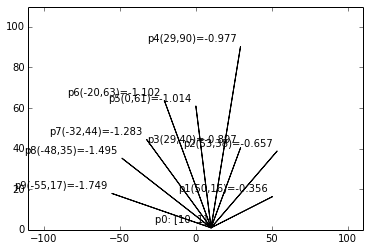

1:  [ 50.40599536  16.3779007 ] [ 53.39512163  38.79382665] [ 29.38926261  40.45084972] -543.066609186
1:  [ 53.39512163  38.79382665] [ 29.38926261  40.45084972] [ 29.35661447  90.35036905] 1197.82672716
1:  [ 53.39512163  38.79382665] [ 29.35661447  90.35036905] [  3.73517274e-15   6.10000000e+01] -2219.06459492
1:  [ 29.35661447  90.35036905] [  3.73517274e-15   6.10000000e+01] [-20.70413862  63.72078659] 687.547192428
1:  [ 29.35661447  90.35036905] [-20.70413862  63.72078659] [-32.32818888  44.49593469] -652.866959504
1:  [-20.70413862  63.72078659] [-32.32818888  44.49593469] [-48.54101966  35.26711514] 204.413008507
1:  [-20.70413862  63.72078659] [-48.54101966  35.26711514] [-55.16127795  17.92298567] -294.4358145
Points:  [array([10,  1]), array([ 50.40599536,  16.3779007 ]), array([ 53.39512163,  38.79382665]), array([ 29.38926261,  40.45084972]), array([ 29.35661447,  90.35036905]), array([  3.73517274e-15,   6.10000000e+01]), array([-20.70413862,  63.72078659]), array([-32.

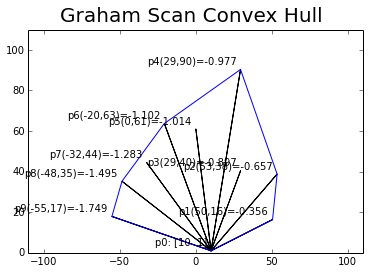

In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random

def CrossProduct(p1, p2):
    (x1, y1) = p1
    (x2, y2) = p2
    return x1*y2 - x2*y1

def Direction(p0, p1, p2):
#    x = np.cross(p2-p0, p1-p0)
    y = CrossProduct( (p2[0]-p0[0], p2[1]-p0[1]), (p1[0]-p0[0], p1[1]-p0[1]) )
    return y

def CalculateRelativePolarAngle(p0, p1):
    p0p1N = p1-p0 # Create vector p0->p1

    # calculate cross-product with x-axis vector (1,0)
    p0p1 = CrossProduct(p0p1N, (1.0,0.0))/math.sqrt(p0p1N[0]**2+p0p1N[1]**2)
    if Direction(p0, (p0[0],p1[1]), p1) < 0 :
        #add 90 degrees when crossing y axis
        p0p1 = -1 - (p0p1 + 1)
    return p0p1

def GrahamScan(points):
    p0 = points[0]
    p1 = points[1]
    p2 = points[2]
    plist = points[3:]
    ch = [p0, p1, p2]
    for p2 in plist:
        p0 = ch[-2]
        p1 = ch[-1]
        print "1: ", p0, p1, p2, Direction(p0,p1,p2)
        while Direction(p0, p1, p2) > 0:
            ch.pop()
            p0 = ch[-2]
            p1 = ch[-1]
        ch.append(p2)
    return ch

def PlotHull(points, ch):
    p0 = points[0]
    plt.suptitle('Graham Scan Convex Hull', fontsize=20)
    plt.xlim(-110,110)
    plt.ylim(0,110)
    plt.annotate('p0: {}'.format(p0), xy=p0, xytext=(-5, 5), ha='right',
                    textcoords='offset points')

    for i in range(1,len(points)):
        p1 = points[i]
        p0p1 = CalculateRelativePolarAngle(p0, p1)
        print "p1->x: ", p0p1
        plt.annotate('p%i(%i,%i)=%.3f'%(i,p1[0],p1[1],p0p1), xy=p1, xytext=(-5, 5), ha='right',
                        textcoords='offset points')
        plt.arrow(p0[0], p0[1], p1[0]-p0[0], p1[1]-p0[1], length_includes_head=True, head_width=0.05, head_length=0.1 )

# Plot Hull
    x = []
    y = []
    for p in ch:
        x.append(p[0])
        y.append(p[1])
    x.append(p0[0])
    y.append(p0[1])
    plt.plot(x,y)

    plt.show()

def test3(n, p0):

    xaxis = np.array([1.0, 0])
    plt.xlim(-110,110)
    plt.ylim(0,110)
    plt.annotate('p0: {}'.format(p0), xy=p0, xytext=(-5, 5), ha='right',
                    textcoords='offset points')
    points = [p0]
    for i in range(1, n):
        r = random.randint(25,95)
        p1 = np.array([r*math.cos((np.pi/n)*i), r*math.sin((np.pi/n)*i)])
        points.append(p1)
        p0p1 = CalculateRelativePolarAngle(p0, p1)
        print "p1->x: ", p0p1
        plt.annotate('p%i(%i,%i)=%.3f'%(i,p1[0],p1[1],p0p1), xy=p1, xytext=(-5, 5), ha='right',
                        textcoords='offset points')
        plt.arrow(p0[0], p0[1], p1[0]-p0[0], p1[1]-p0[1], length_includes_head=True, head_width=0.05, head_length=0.1 )

    plt.show()
    return points

points = test3( 10, np.array([10,1]) )
ch = GrahamScan(points)
print "Points: ", points
print ch
PlotHull(points, ch)